In [1]:
import numpy as np
from loadmodules import *
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.mixture import GaussianMixture
from matplotlib import ticker
from parallel_decorators import vectorize_parallel
import gc

%matplotlib inline
rcParams['figure.facecolor'] = 'white'

In [2]:
@vectorize_parallel(method='processes', num_procs=10)
def get_insitu_ids(snap, path, sim):
    s = gadget_readsnap(snap-1, snappath=path+sim+'/output/', onlyHeader=True)
    low_time = s.time
    sf = load_subfind(snap, dir=path+sim+'/output/', hdf5=True, loadonly=['fpos', 'fmc2', 'frc2', 'svel', 'flty', 'fmty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(snap, snappath=path+sim+'/output/', subfind=sf, hdf5=True, applytransformationfacs=True, loadonlyhalo=0, loadonlytype=[4])
    if len(s.data)>0:
        s.calc_sf_indizes( sf )
        new_insitu = s.data['id'][(s.data['age']>=low_time) * (s.data['subhalo']==0) * (s.data['incl']>0)]
    else:
        new_insitu = np.array([])
    return new_insitu

In [3]:
def get_radial_distribution_in_ex_situ_fractions(path, simulation, snapshot, bins, insitu_ids):
    print('Loading simulation ', simulation, ' snapshot ', snapshot)
    sf = load_subfind(snapshot, dir=path+simulation+'/output/', hdf5=True, loadonly=['fpos', 'fmc2', 'frc2', 'svel', 'flty', 'fmty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
    s = gadget_readsnap(snapshot, snappath=path+simulation+'/output/', subfind=sf, hdf5=True, applytransformationfacs=True, loadonlyhalo=0, loadonlytype=[4])
    s.calc_sf_indizes( sf )
    s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )
    galrad = sf.data['frc2'][0]

    starparts = (s.data['age']>0.) * (s.r()<galrad) * (s.data['subhalo']==0)

    Lz = pylab.cross( s.data['pos'], (s.data['vel'] ) )[:,0]
    orbital_energy = s.data['pot'] + 0.5 * np.sum(s.data['vel']**2, axis=1)

    mask_clusters_final = (s.data['nclt'][starparts] > 0 )

    jz = Lz[starparts]
    ii = np.argsort(orbital_energy[starparts])
    eps = jz[ii]
    npm = 50
    eps /= [ np.max(eps[:i+npm]) if i < npm else np.max(eps[i-npm:]) if i > size(ii)-npm else np.max(eps[i-npm:i+npm]) for i in range(size(ii)) ]
    ilist = np.array(list(range(0, len(eps))))# ilist=1,2,3,4,5
    ilist = ilist[ii] # ilist=5,4,3,2,1
    resort = np.argsort(ilist) # resort=5,4,3,2,1
    eps = eps[resort] # eps2=5,4,3,2,1

    # Build feature array: [ε, Energy]
    X = np.vstack((eps,orbital_energy[starparts],
                    np.log10(np.abs(s.data['pos'][:,0][starparts])))).T

    # Fit GMM
    gmm = GaussianMixture(n_components=2, means_init=[[0.0,np.median(orbital_energy[starparts]), -2.0],
                                                      [0.9,np.median(orbital_energy[starparts]), -3.0]],
                                                       covariance_type='full', random_state=42)
    gmm.fit(X)

    # Predict cluster memberships
    decomp_labels = gmm.predict(X)
    median_eps = [np.median(eps[decomp_labels==i]) for i in range(gmm.n_components)]
    sph_label = np.argmin(median_eps)
    disc_label = np.argmax(median_eps)

    #Force assign disc_label to clusters with high circularity
    mask = (decomp_labels == sph_label) & (eps > 0.7) & (s.r()[starparts] < np.percentile(s.r()[starparts][decomp_labels == disc_label], 0.75))
    decomp_labels[mask] = disc_label
    
    mask_decomposition = decomp_labels[mask_clusters_final] == sph_label
    
    init_cluster_masses = s.data['imcl'][starparts][mask_clusters_final][mask_decomposition].flatten()
    cluster_masses = s.data['mclt'][starparts][mask_clusters_final][mask_decomposition].flatten()

    stars_formtime = s.data['age'][starparts][mask_clusters_final][mask_decomposition]
    stars_age = s.cosmology_get_lookback_time_from_a(stars_formtime, is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True)
    clusters_formtime = np.repeat(stars_formtime, s.data['nclt'][starparts][mask_clusters_final][mask_decomposition])
    clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True)
    clusters_radii = np.repeat(s.r()[starparts][mask_clusters_final][mask_decomposition], s.data['nclt'][starparts][mask_clusters_final][mask_decomposition])

    low_mass_cut = 1e5

    init_mass_cut = (1e10*init_cluster_masses[cluster_masses>0]>low_mass_cut)
    age_cut_6gyr = (clusters_age>6.)

    radial_hist, _ = np.histogram(1e3*clusters_radii[init_mass_cut * age_cut_6gyr], bins=bins)
    radial_density_profile_6gyr = radial_hist / (4.*np.pi*( (bins[1:]**3 - bins[:-1]**3)/3. ))

    age_cut_10gyr = (clusters_age>10.)

    radial_hist, _ = np.histogram(1e3*clusters_radii[init_mass_cut * age_cut_10gyr], bins=bins)
    radial_density_profile_10gyr = radial_hist / (4.*np.pi*( (bins[1:]**3 - bins[:-1]**3)/3. ))

    # """Read the accreted particle files with a gadget_readsnap() method"""
    # list_directory = './lists/accretedstardata/%s/'%simulation
    # s.read_starparticle_mergertree_data_hdf5(snapshot, list_directory,'')
    # print(s.mdata)

    gc_cand = (((1e10*s.data['imcl'][starparts][mask_clusters_final][mask_decomposition])>1e5).any(axis=1))
    # gcinsitu_index, = np.where( np.isin( s.data['id'][starparts][mask_clusters_final][mask_decomposition][gc_cand], s.mdata['Insitu']['ParticleIDs']) )
    
    # index_accreted, = np.where((s.mdata['Exsitu']['AccretedFlag']==0))
    # gcexsitu_index, = np.where( np.isin( s.data['id'][starparts][mask_clusters_final][mask_decomposition][gc_cand], s.mdata['Exsitu']['ParticleIDs'][index_accreted]) )
    
    gcinsitu_index, = np.where( np.isin( s.data['id'][starparts][mask_clusters_final][mask_decomposition][gc_cand], insitu_ids) )
    insitu_radii = s.r()[starparts][mask_clusters_final][mask_decomposition][gc_cand][gcinsitu_index]
    exsitu_radii = s.r()[starparts][mask_clusters_final][mask_decomposition][gc_cand][~gcinsitu_index]
    
    N_insitu, _ = np.histogram(1e3*insitu_radii, bins=bins)
    N_exsitu, _ = np.histogram(1e3*exsitu_radii, bins=bins)

    return radial_density_profile_6gyr,radial_density_profile_10gyr, N_insitu, N_exsitu

In [10]:
path = './'
original_mw = sorted([directory for directory in os.listdir(path) if 'Au' in directory and 'cfea_fiducial' in directory])
lowmass_mw = sorted([directory for directory in os.listdir(path) if 'L' in directory and 'cfea_fiducial' in directory])
dwarfs = sorted([directory for directory in os.listdir(path) if 'D' in directory and 'cfea_fiducial' in directory])

simulation_list = original_mw + lowmass_mw + dwarfs
simulation_list.remove('Au17_lvl4_cfea_fiducial')

In [11]:
snaps = np.arange(20, 128, 1, dtype=int)

In [12]:
ids_insitu = []
for sim in simulation_list:
    if os.path.exists(path+sim+'/output/insitu_gcs_ids.npy'):
        insitu_ids = np.load(path+sim+'/output/insitu_gcs_ids.npy')
        ids_insitu.append( insitu_ids )
        print('Insitu ids loaded from file for sim', sim)
    else:
        print('Doing sim', sim)
        sim_insitu_ids = np.concatenate(get_insitu_ids(snaps, path, sim))
        np.save(path+sim+'/output/insitu_gcs_ids.npy', sim_insitu_ids)
        ids_insitu.append( sim_insitu_ids )
        print('Saved ids for sim', sim)

Insitu ids loaded from file for sim Au06_lvl4_cfea_fiducial
Insitu ids loaded from file for sim Au14_lvl4_cfea_fiducial
Insitu ids loaded from file for sim Au18_lvl4_cfea_fiducial
Insitu ids loaded from file for sim Au22_lvl4_cfea_fiducial
Insitu ids loaded from file for sim Au23_lvl4_cfea_fiducial
Insitu ids loaded from file for sim Au24_lvl4_cfea_fiducial
Insitu ids loaded from file for sim Au26_lvl4_cfea_fiducial
Insitu ids loaded from file for sim Au27_lvl4_cfea_fiducial
Insitu ids loaded from file for sim Au28_lvl4_cfea_fiducial
Doing sim L01_lvl4_cfea_fiducial
Saved ids for sim L01_lvl4_cfea_fiducial
Doing sim L10_lvl4_cfea_fiducial
Saved ids for sim L10_lvl4_cfea_fiducial
Doing sim D04_lvl4_cfea_fiducial
Saved ids for sim D04_lvl4_cfea_fiducial
Doing sim D07_lvl4_cfea_fiducial
Saved ids for sim D07_lvl4_cfea_fiducial
Doing sim D10_lvl4_cfea_fiducial
Saved ids for sim D10_lvl4_cfea_fiducial


In [53]:
mw_catalogue = np.genfromtxt('catalogues_compare/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_radii = mw_catalogue[:,2]
bins = np.logspace(-1, 2.5, 22)
mw_hist, _ = np.histogram(mw_radii, bins=bins)
mw_density = mw_hist / (4.*np.pi*( (bins[1:]**3 - bins[:-1]**3)/3. ))

In [ ]:
radial_dist_6gyr = []
radial_dist_10gyr = []
N_insitu_dist = []
N_exsitu_dist = []

for i, simulation in enumerate(simulation_list):
    radial_profile_6gyr, radial_profile_10gyr, N_insitu, N_exsitu = get_radial_distribution_in_ex_situ_fractions(path, simulation, 127, bins, ids_insitu[i])
    radial_dist_6gyr.append(radial_profile_6gyr)
    radial_dist_10gyr.append(radial_profile_10gyr)
    N_insitu_dist.append(N_insitu)
    N_exsitu_dist.append(N_exsitu)

Loading simulation  Au06_lvl4_cfea_fiducial  snapshot  127
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated vel.
Loading simulation  Au14_lvl4_cfea_fiducial  snapshot  127
galrad= 0.024826176
Found 2875263 stars.
Rotated pos.
Rotated vel.
Loading simulation  Au18_lvl4_cfea_fiducial  snapshot  127
galrad= 0.021988682
Found 1937847 stars.
Rotated pos.
Rotated vel.
Loading simulation  Au22_lvl4_cfea_fiducial  snapshot  127
galrad= 0.020834247
Found 1527247 stars.
Rotated pos.
Rotated vel.
Loading simulation  Au23_lvl4_cfea_fiducial  snapshot  127
galrad= 0.024249291
Found 1704041 stars.
Rotated pos.
Rotated vel.
Loading simulation  Au24_lvl4_cfea_fiducial  snapshot  127
galrad= 0.024267228
Found 1735362 stars.
Rotated pos.
Rotated vel.
Loading simulation  Au26_lvl4_cfea_fiducial  snapshot  127
galrad= 0.02422835
Found 2664011 stars.
Rotated pos.
Rotated vel.
Loading simulation  Au27_lvl4_cfea_fiducial  snapshot  127
galrad= 0.025470624
Found 2678961 stars.
Rotated pos.
Rotate

In [58]:
def first_char_index(text, char):
    """
    Returns the index of the first appearance of `char` in `text`.
    Returns -1 if `char` is not found.
    """
    try:
        return text.index(char)
    except ValueError:
        return -1

/tmp/ipykernel_205036/2142968085.py:14: RuntimeWarning: invalid value encountered in divide
  ax[1].loglog((bins[1:]+bins[:-1])/2., N_insitu_dist[i]/(N_insitu_dist[i] + N_exsitu_dist[i]), linestyle='dashed', linewidth=0.5, alpha=0.5, color='grey')
/tmp/ipykernel_205036/2142968085.py:15: RuntimeWarning: invalid value encountered in divide
  ax[1].loglog((bins[1:]+bins[:-1])/2., N_exsitu_dist[i]/(N_insitu_dist[i] + N_exsitu_dist[i]), linewidth=0.5, alpha=0.5, color='grey')
/tmp/ipykernel_205036/2142968085.py:19: RuntimeWarning: invalid value encountered in divide
  ax[1].loglog((bins[1:]+bins[:-1])/2., N_insitu/(N_insitu + N_exsitu), linewidth=2, label='Median,'+'\n'+'in-situ GCs', color='k')
/tmp/ipykernel_205036/2142968085.py:20: RuntimeWarning: invalid value encountered in divide
  ax[1].loglog((bins[1:]+bins[:-1])/2., N_exsitu/(N_insitu + N_exsitu), linewidth=2, label='Median,'+'\n'+'ex-situ GCs', color='r')


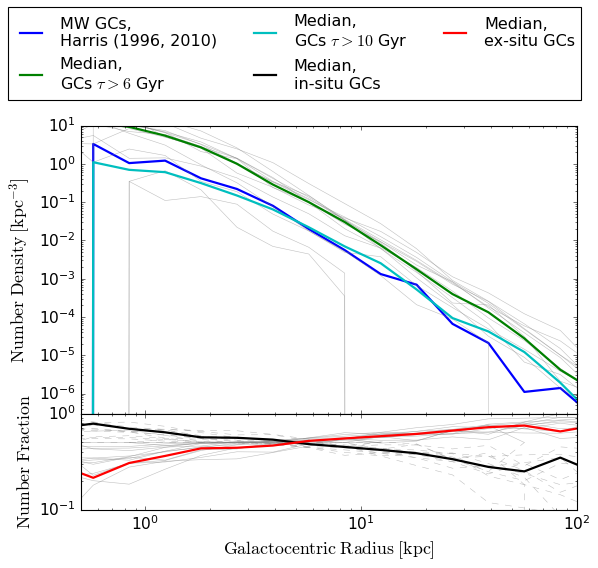

In [ ]:
line_colors = cm.plasma(np.linspace(0,1,len(simulation_list)))
fig, ax = plt.subplots(2, 1, sharex=True, height_ratios=[3,1])
ax[0].loglog((bins[1:] + bins[:-1]) / 2., mw_density, linewidth=4, label='MW GCs,'+'\n'+'Harris (1996, 2010)')
for i in range(len(simulation_list)):
    ax[0].loglog((bins[1:] + bins[:-1]) / 2., radial_dist_6gyr[i], linewidth=0.5, alpha=0.5, color='grey')
ax[0].loglog((bins[1:] + bins[:-1])/2., np.median(np.array(radial_dist_6gyr), axis=0), linewidth=4, label='Median,'+'\n'+r'GCs $\tau > 6$ Gyr')
ax[0].loglog((bins[1:] + bins[:-1])/2., np.median(np.array(radial_dist_10gyr), axis=0), linewidth=4, c='c', linestyle='--', label='Median,'+'\n'+r'GCs $\tau > 10$ Gyr')
ax[0].set_ylim(3e-7, 1e1)
ax[0].set_ylabel(r'$\mathrm{Number \; Density \; [kpc^{-3}]}$', fontsize=16)
# ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', which='both', labelsize=14)

for i in range(len(simulation_list)):
    ax[1].loglog((bins[1:]+bins[:-1])/2., N_insitu_dist[i]/(N_insitu_dist[i] + N_exsitu_dist[i]), linestyle='dashed', linewidth=0.5, alpha=0.5, color='grey')
    ax[1].loglog((bins[1:]+bins[:-1])/2., N_exsitu_dist[i]/(N_insitu_dist[i] + N_exsitu_dist[i]), linewidth=0.5, alpha=0.5, color='grey')

N_insitu = np.median(np.array(N_insitu_dist), axis=0)
N_exsitu = np.median(np.array(N_exsitu_dist), axis=0)
ax[1].loglog((bins[1:]+bins[:-1])/2., N_insitu/(N_insitu + N_exsitu), linewidth=4, label='Median,'+'\n'+'in-situ GCs', color='k')
ax[1].loglog((bins[1:]+bins[:-1])/2., N_exsitu/(N_insitu + N_exsitu), linewidth=4, label='Median,'+'\n'+'ex-situ GCs', color='r')
ax[1].set_ylabel(r'$\rm{N. \; Fraction}$', fontsize=16)
# ax[1].legend(loc='upper left', fontsize=14)
ax[1].tick_params(axis='both', which='both', labelsize=14)
ax[1].set_xlabel(r'$\mathrm{Galactocentric \; Radius \; [kpc]}$', fontsize=16)
ax[1].set_xlim(5e-1, 1e2)
ax[1].set_ylim(1e-1, 1)

# Collect handles and labels from all axes (including twin axes) except the last one
handles = []
labels = []
for a in fig.axes:
    # if a is ax_last:
    #     continue
    h, l = a.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Keep unique labels in order
seen = set()
unique_handles = []
unique_labels = []
for h, l in zip(handles, labels):
    if l and l not in seen:
        seen.add(l)
        unique_handles.append(h)
        unique_labels.append(l)

fig.legend(unique_handles, unique_labels, loc='center', bbox_to_anchor=(0.46, 1.05), frameon=True, ncol=3)

plt.subplots_adjust(hspace=0.0)
plt.savefig('./plots/insitu_exsitu_gcs_paper.pdf', bbox_inches='tight')